In [136]:
import pandas as pd
import requests
import geopandas as gpd
from shapely.geometry import Point

In [137]:
app_token = "Rl5BUiRawpr4H2LA9OQeKB47L"

# 1 Data Preprocessing

## 1.1 Download 311 data and 2015 tree cencus data

In [139]:
from datetime import datetime, timedelta

def generate_month_ranges(start_date, end_date):
    current = start_date
    temp = 0
    while current < end_date:
        temp += 1
        month_end = current.replace(day=1) + timedelta(days=32)
        month_end = month_end.replace(day=1) - timedelta(days=1) # 9 30
        yield (current, month_end)
        current = month_end + timedelta(days=1)
        if temp == 100:
            break

#Set start date and end ate
start_date = datetime(2015, 1, 1)
end_date = datetime(2023, 9, 30)

#Generate month's range
month_ranges = list(generate_month_ranges(start_date, end_date))

In [140]:
import os

for start, end in month_ranges:
    year = start.year
    csv_file = f"data/complaints_data_{year}.csv"
    print(f"Downloading data for the period: {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")

    query = f"created_date between '{start.strftime('%Y-%m-%dT%H:%M:%S')}' and '{end.strftime('%Y-%m-%dT%H:%M:%S')}'"
    response = requests.get(
        url="https://data.cityofnewyork.us/resource/erm2-nwe9.json",
        params={"$$app_token": app_token, "$where": query, "$limit": 999999,
                "$select": "unique_key, created_date, closed_date, agency,  complaint_type, descriptor, location_type, incident_zip, latitude, longitude, borough"
                }
    )
    data = response.json()
    batch_df = pd.DataFrame(data)

    # 根据年份写入或追加到对应的CSV文件
    mode = 'a' if os.path.exists(csv_file) else 'w'
    batch_df.to_csv(csv_file, mode=mode, index=False, header=not os.path.exists(csv_file))

print("Data download complete.")

Data download complete.


In [142]:
tree_data = requests.get(url="https://data.cityofnewyork.us/resource/5rq2-4hqu.json",
                         params={"$$app_token": app_token, "$limit": 99999999999999999999}).json()
tree_df = pd.DataFrame(tree_data)
tree_df.to_csv("data/tree.csv")

## 1.2 Data Cleaning & Filtering

### 1.2.1 311 Data Cleaning & Filtering

In [143]:
def clean_311_data(datafile):
    import pandas as pd
    import numpy as np
    import datetime
    import geopandas as gpd
    from shapely.geometry import Point
    
    #Add fix_zip function
    def fix_zip(input_zip):
        try:
            input_zip = int(float(input_zip))
        except:
            try:
                input_zip = int(input_zip.split('-')[0])
            except:
                return np.NaN
        if input_zip < 10000 or input_zip > 12000:
            return np.NaN
        return str(input_zip)

    #Read the file
    df = pd.read_csv(datafile, low_memory=False)

    #fix the zip
    df['incident_zip'] = df['incident_zip'].apply(fix_zip)

    df = df.dropna(how='any')

    #get rid of unspecified boroughs
    df = df[df['borough'] != 'Unspecified']

    df['latitude'] = df['latitude'].astype('float64')
    df['longitude'] = df['longitude'].astype('float64')

    #Converts the 'closed_date','created_date' column into a datetime object
    df['created_date'] = pd.to_datetime(df['created_date'])
    df['closed_date'] = pd.to_datetime(df['closed_date'])
    # Convert longitude and latitude to a 'geometry' column for geopandas
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

    # Create a GeoDataFrame and set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs(epsg=4326, inplace=True)
    gdf = gdf.reset_index(drop=True)
    
    return gdf

### 1.2.2 2015 Tree census Data Cleaning & Filtering

In [144]:
tree = pd.read_csv('data/tree.csv', usecols=['tree_id', 'the_geom',   'spc_common', 'status', 'health', 'zipcode', 'boroname', 'latitude', 'longitude'])
tree.to_csv('data/tree_data.csv',index=False)

In [145]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point


def clean_tree_data(datafile):

    # Add fix_zip function
    def fix_zip(input_zip):
        try:
            input_zip = int(float(input_zip))
        except:
            try:
                input_zip = int(input_zip.split('-')[0]) 
            except:
                return np.NaN
        if input_zip < 10000 or input_zip > 12000:
            return np.NaN
        return str(input_zip)

    # Read the file
    df = pd.read_csv(datafile)

    # Fix the zip
    df['zipcode'] = df['zipcode'].apply(fix_zip)

    df = df.dropna(how='any')

    # Make some columns name readable
    df.rename(columns={'the_geom': 'geometry', 'spc_common': 'species', 'boroname': 'borough'}, inplace=True)

    # Convert longitude and latitude to a 'geometry' column for geopandas
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

    # Create a GeoDataFrame and set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs(epsg=4326, inplace=True)
    gdf = gdf.reset_index(drop=True)


    return gdf

In [146]:
tree = clean_tree_data('data/tree_data.csv')
tree.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 651235 entries, 0 to 651234
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   tree_id    651235 non-null  int64   
 1   geometry   651235 non-null  geometry
 2   status     651235 non-null  object  
 3   health     651235 non-null  object  
 4   species    651235 non-null  object  
 5   zipcode    651235 non-null  object  
 6   borough    651235 non-null  object  
 7   latitude   651235 non-null  float64 
 8   longitude  651235 non-null  float64 
dtypes: float64(2), geometry(1), int64(1), object(5)
memory usage: 44.7+ MB


### 1.2.3 Zillow Data Cleaning & Filtering

In [147]:
def clean_zillow_data(datafile):
    import pandas as pd

    df = pd.read_csv(datafile, low_memory=False)

    df = df[df['City'] == 'New York']

    # Select the 'RegionName' and 'CountyName' columns and store them in df1
    df1 = df[['RegionName', 'CountyName']]
    # Select all columns from '2018-09-30' onwards and store them in df2
    df2 = df.loc[:, '2018-09-30':]

    # Concatenate df1 and df2 along the columns (axis=1)
    df = pd.concat([df1, df2], axis=1)

    # Make columns' name more readable
    df.rename(columns={'RegionName': 'zipcode', 'CountyName': 'county'}, inplace=True)

    # Convert the 'zipcode' column to a string data type
    df['zipcode'] = df['zipcode'].astype(str)

    df = df.melt(id_vars=["zipcode", "county"], var_name="date")
    
    df = df.reset_index(drop=True)

    return df

In [148]:
zillow = clean_zillow_data('data/zillow_rent_data.csv')
zillow.head()

,zipcode,county,date,value
0,11385,Queens County,2018-09-30,2401.525193
1,11208,Kings County,2018-09-30,NaN
2,11236,Kings County,2018-09-30,NaN
3,10467,Bronx County,2018-09-30,1773.839053
4,11373,Queens County,2018-09-30,NaN


### 1.2.4 Zipcode data Cleaning & Filtering

In [153]:
def clean_zipcode_data(datafile):
    import geopandas as gpd

    gdf = gpd.read_file(datafile)
    if gdf.crs is None:
        gdf = gdf.set_crs('EPSG:4326')
    gdf = gdf.to_crs('EPSG:4326')
    #Select specific columns
    gdf = gdf[['ZIPCODE', 'POPULATION', 'geometry' ]]

    gdf.rename(columns={'ZIPCODE':'zipcode', 'POPULATION':'population'}, inplace=True)
    gdf = gdf.reset_index(drop=True)
    

    return gdf

In [154]:
zipcode = clean_zipcode_data('data/nyc_zipcodes.shp')
print(zipcode.head())


  zipcode  population                                           geometry
0   11436     18681.0  POLYGON ((1038098.25187 188138.38001, 1038141....
1   11213     62426.0  POLYGON ((1001613.71296 186926.43952, 1002314....
2   11212     83866.0  POLYGON ((1011174.27554 183696.33771, 1011373....
3   11225     56527.0  POLYGON ((995908.36545 183617.61280, 996522.84...
4   11218     72280.0  POLYGON ((991997.11343 176307.49586, 992042.79...


# 2 Storing Data

## 2.1 Creating database

In [200]:
!createdb FINAL_PROJECT
!psql --dbname FINAL_PROJECT -c 'CREATE EXTENSION postgis;'
!psql --dbname FINAL_PROJECT -f schema.sql

createdb: error: database creation failed: ERROR:  database "FINAL_PROJECT" already exists
ERROR:  extension "postgis" already exists
psql:schema.sql:7: NOTICE:  relation "nyc_zip_codes" already exists, skipping
CREATE TABLE
psql:schema.sql:19: NOTICE:  relation "treecensus_2015" already exists, skipping
CREATE TABLE
psql:schema.sql:27: NOTICE:  relation "zillow_average_rents" already exists, skipping
CREATE TABLE
psql:schema.sql:42: NOTICE:  relation "complaints311_2023" already exists, skipping
CREATE TABLE


In [179]:
import psycopg2

In [201]:
conn = psycopg2.connect("dbname=FINAL_PROJECT user=postgres password=123456")
cur = conn.cursor()

## 2.2 Creating tables

In [202]:
create_nyc_zipcodes_table = """
    CREATE TABLE IF NOT EXISTS nyc_zip_codes (
        id INTEGER PRIMARY KEY,
        zipcode INTEGER NOT NULL,
        population INTEGER,
        geometry geometry(Geometry, 4326)
    );
"""

In [203]:
create_trees_table = """
    CREATE TABLE IF NOT EXISTS treecensus_2015 (
        id INTEGER PRIMARY KEY,
        geometry geometry(Geometry, 4326),
        status VARCHAR,
        health VARCHAR,
        species VARCHAR,
        zipcode INTEGER,
        borough VARCHAR,
        latitude FLOAT,
        longitude FLOAT
    );
"""

In [204]:
create_zillow_table = """
    CREATE TABLE IF NOT EXISTS zillow_average_rents(
        id INTEGER PRIMARY KEY,
        zipcode INTEGER,
        county VARCHAR,
        date DATE,
        value FLOAT
    );
"""

In [206]:
import psycopg2

conn = psycopg2.connect("dbname=FINAL_PROJECT user=postgres password=123456")
cur = conn.cursor()

In [207]:
cur.execute(create_nyc_zipcodes_table)
conn.commit()

In [208]:
cur.execute(create_nyc_zipcodes_table)
cur.execute(create_trees_table)
cur.execute(create_zillow_table)
conn.commit()

In [209]:
conn = psycopg2.connect("dbname=FINAL_PROJECT user=postgres password=123456")
cur = conn.cursor()

#Creating 311 tables by years
for year in range(2015, 2024):
    table_name = f"complaints311_{year}"
    create_table_query = f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            id INTEGER PRIMARY KEY,
            created_date DATE,
            closed_date DATE,
            agency VARCHAR,
            complaint_type VARCHAR,
            descriptor VARCHAR,
            location_type VARCHAR,
            incident_zip INTEGER,
            latitude FLOAT,
            longitude FLOAT,
            borough VARCHAR,
            geometry geometry(Geometry, 4326)
        );
    """

    cur.execute(create_table_query)


conn.commit()

## 2.3 Inserting data

### 2.3.1 Inserting tree data

In [210]:
import psycopg2
from shapely import wkt  # Import the Well-Known Text (WKT) module from Shapely

# Assuming you have a function clean_tree_data that reads and processes the CSV
gdf = clean_tree_data('data/tree_data.csv')

# Connect to PostgreSQL
conn = psycopg2.connect("dbname=FINAL_PROJECT user=postgres password=123456")
cur = conn.cursor()

# Define the table schema
create_trees_table = """
    CREATE TABLE IF NOT EXISTS treecensus_2015 (
        id INTEGER PRIMARY KEY,
        geometry geometry(Point, 4326),
        status VARCHAR,
        health VARCHAR,
        species VARCHAR,
        zipcode INTEGER,
        borough VARCHAR,
        latitude FLOAT,
        longitude FLOAT
    );
"""
cur.execute(create_trees_table)
conn.commit()
gdf=clean_tree_data('data/tree_data.csv')
# Prepare data for insertion
data_to_insert = [
    (row.Index, wkt.dumps(row.geometry), row.status, row.health, row.species, row.zipcode, row.borough, row.latitude, row.longitude)
                  for row in gdf.itertuples()]

# Insert data into the table
insert_query = """
    INSERT INTO treecensus_2015 (id, geometry, status, health, species, zipcode, borough, latitude, longitude)
    VALUES (%s, ST_GeomFromText(%s, 4326), %s, %s, %s, %s,%s, %s, %s);
"""
cur.executemany(insert_query, data_to_insert)

# Commit the changes
conn.commit()

# Close the connection
conn.close()

UniqueViolation: duplicate key value violates unique constraint "treecensus_2015_pkey"
DETAIL:  Key (id)=(0) already exists.


### 2.3.2 Inserting 311 data

In [190]:
import psycopg2
from shapely import wkt

# Connect to the PostgreSQL database
conn = psycopg2.connect("dbname=final_project user=postgres password=123456")
cur = conn.cursor()

for year in range(2015, 2024):
    # Clean the data
    complaints = clean_311_data(f"data/complaints_data_{year}.csv")


    print(year)

    # Prepare the SQL statement for data insertion, dynamically updating the table name
    insert_query = f"""
        INSERT INTO complaints311_{year} (id, created_date, closed_date, agency, complaint_type, descriptor, location_type, incident_zip, latitude, longitude, borough, geometry)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, ST_GeomFromText(%s, 4326));
    """

    # Prepare the data to be inserted
    data_to_insert = [
        (row.Index, row.created_date, row.closed_date, row.agency, row.complaint_type, row.descriptor, row.location_type, row.incident_zip, row.latitude, row.longitude, row.borough, wkt.dumps(row.geometry))
        for row in complaints.itertuples()]

    # Execute the insertion
    cur.executemany(insert_query, data_to_insert)

    # Commit the changes
    conn.commit()

# Close the connection
conn.close()


2018


UndefinedTable: relation "complaints311_2018" does not exist
LINE 2:         INSERT INTO complaints311_2018 (id, created_date, cl...
                            ^


### 2.3.3 Inserting zillow data

In [110]:
import psycopg2
from shapely import wkt
# Connect to PostgreSQL
conn = psycopg2.connect("dbname=final_project user=postgres password=123456")
cur = conn.cursor()

# Prepare data for insertion
data_to_insert = [
    (row.Index,  row.zipcode, row.county, row.date, row.value)
    for row in zillow.itertuples()]

# Insert data into the table
insert_query = """
    INSERT INTO zillow_average_rents (id,  zipcode, county, date, value)
    VALUES ( %s, %s,%s, %s, %s);
"""
cur.executemany(insert_query, data_to_insert)

# Commit the changes
conn.commit()

# Close the connection
conn.close()

NameError: name 'zillow' is not defined

### 2.3.4 Inserting zipcodes data

In [119]:
import psycopg2
from shapely import wkt
# Connect to PostgreSQL
conn = psycopg2.connect("dbname=final_project user=postgres password=123456")
cur = conn.cursor()

# Prepare data for insertion
data_to_insert = [
    (row.Index,  row.zipcode, row.population, wkt.dumps(row.geometry) )
    for row in zipcode.itertuples()]

# Insert data into the table
insert_query = """
    INSERT INTO nyc_zip_codes (id,  zipcode, population, geometry)
    VALUES ( %s, %s,%s, ST_GeomFromText(%s, 4326));
"""
cur.executemany(insert_query, data_to_insert)

# Commit the changes
conn.commit()

# Close the conn
conn.close()

# 3 Understanding Data

## 3.1 Query 1: Which area might be more calm to live in?


In [130]:
import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect("dbname=final_project user=postgres password=123456")
cur = conn.cursor()

# Execute the SQL query
query_1 = """
    SELECT 
        incident_zip AS zipcode,
        COUNT(*) AS number_of_complaints
     FROM
        (SELECT * FROM complaints311_2022 WHERE created_date >= '2022-10-01'
         UNION ALL
         SELECT * FROM complaints311_2023 WHERE created_date <= '2023-09-30') AS combined_data
    WHERE  
        created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY
        incident_zip
    ORDER BY
        number_of_complaints DESC
"""

cur.execute(query_1)
result = cur.fetchall()
print(result)

conn.commit()
conn.close()

#Save the query to a sql file
with open('calm_areas_by_complaints.sql', 'w') as file:
    file.write(query_1)

[(11226, 42497), (10467, 41184), (10468, 38912), (10452, 38476), (10457, 36608), (10458, 36032), (10456, 35311), (11385, 35116), (10453, 33610), (11207, 33115), (11201, 31121), (11208, 30691), (10031, 29073), (10466, 28528), (10032, 28091), (11221, 26970), (10462, 25574), (11368, 24532), (11230, 24208), (10025, 23542), (11238, 23364), (11225, 23253), (10460, 23219), (11220, 23090), (11212, 23022), (10463, 22656), (11216, 22265), (10472, 22115), (11203, 21958), (11214, 21869), (11235, 21643), (10027, 21536), (11213, 21514), (11377, 20719), (11233, 20672), (10033, 20505), (11101, 20025), (11218, 20007), (11209, 19712), (11206, 19602), (10002, 19472), (11223, 19462), (11222, 19364), (10034, 19281), (10023, 19169), (11373, 19138), (11211, 18907), (10019, 18828), (11234, 18756), (10026, 18453), (10461, 18359), (11237, 18331), (11215, 18166), (11236, 17763), (11229, 17365), (10469, 17198), (11204, 17151), (10459, 17125), (10040, 17105), (10451, 16841), (10029, 16721), (11210, 16702), (11372,

## 3.2 Query 2: Where has the most greenery?


In [131]:
conn = psycopg2.connect("dbname=final_project user=postgres password=123456")
cur = conn.cursor()

# Execute the SQL query to find the top 10 zip codes with the most trees
query_2 = """
    SELECT 
        zipcode,
        COUNT(*) AS total_trees
    FROM
        tree_census_2015
    GROUP BY
        zipcode
    ORDER BY
        total_trees DESC
    LIMIT 10;
"""

cur.execute(query_2)
result = cur.fetchall()

print(result)

conn.commit()
conn.close()

#Save the query to a sql file
with open('top_10_green_zipcodes.sql', 'w') as file:
    file.write(query_2)

[(10312, 21356), (10314, 16330), (10306, 12616), (10309, 12105), (11234, 10838), (11385, 10262), (11357, 9016), (11207, 8293), (11208, 7896), (11434, 7833)]


## 3.3 Query 3: Can I afford a place in the areas with the most trees?


In [132]:
conn = psycopg2.connect("dbname=final_project user=postgres password=123456")
cur = conn.cursor()

# Execute the SQL query to find the average rent for the top 10 zip codes with the most trees
query_3 = """
    WITH TopZipCodes AS (
    SELECT 
        zipcode,
        COUNT(*) AS total_trees
    FROM 
        tree_census_2015
    GROUP BY 
        zipcode
    ORDER BY 
        COUNT(*) DESC
    LIMIT 10
    )
    SELECT 
    TopZipCodes.zipcode,
    total_trees,
    ROUND(CAST(AVG(zillow_rents.value) AS numeric), 2) AS average_rent
    FROM 
        TopZipCodes
    JOIN 
        zillow_rents ON TopZipCodes.zipcode = zillow_rents.zipcode
    WHERE 
        zillow_rents.date = '2023-08-31'
    GROUP BY 
        TopZipCodes.zipcode, total_trees
    ORDER BY 
        total_trees DESC;

"""

cur.execute(query_3)
result = cur.fetchall()
#Convert Decimal type into python float
result = [(zipcode, float(rent)) for zipcode, tree, rent in result]

print(result)

conn.commit()
conn.close()

#Save the query to a sql file
with open('affordable_green_areas_rent.sql', 'w') as file:
    file.write(query_3)

[(10312, 1775.09), (10314, 2465.47), (10306, 2331.54), (10309, 1832.01), (11234, 2312.31), (11385, 3064.48), (11357, 2458.81), (11207, 3079.09), (11208, 2737.55), (11434, 2645.92)]


## 3.4 Query 4: Could there be a correlation between an area’s rent, the number of its trees, and the number of 311 complaints?


In [133]:
conn = psycopg2.connect("dbname=final_project user=postgres password=123456")
cur = conn.cursor()

# Execute the SQL query to find the 5 zip codes with the lowest and highest average rent for January 2023
query_4 = """
    WITH HighRent AS (
    SELECT 
        zillow_rents.zipcode,
        zillow_rents.value AS rent,
        RANK() OVER (ORDER BY zillow_rents.value DESC) AS rent_rank
    FROM 
        zillow_rents
    WHERE 
        zillow_rents.date = '2023-01-31' AND zillow_rents.value != 'NaN'
    ORDER BY 
        zillow_rents.value DESC 
    LIMIT 5
    ),
    LowRent AS (
        SELECT 
            zillow_rents.zipcode,
            zillow_rents.value AS rent,
            RANK() OVER (ORDER BY zillow_rents.value) AS rent_rank
        FROM 
            zillow_rents
        WHERE 
            zillow_rents.date = '2023-01-31' AND zillow_rents.value != 'NaN'
        ORDER BY 
            zillow_rents.value
        LIMIT 5
    ),
    TreeCount AS (
        SELECT 
            tree_census_2015.zipcode,
            COUNT(*) AS tree_count
        FROM 
            tree_census_2015
        GROUP BY 
            tree_census_2015.zipcode
    ),
    ComplaintCount AS (
        SELECT 
            complaints311_2023.incident_zip AS zipcode,
            COUNT(*) AS complaint_count
        FROM 
            complaints311_2023
        WHERE 
            complaints311_2023.created_date BETWEEN '2023-01-01' AND '2023-01-31'
        GROUP BY 
            complaints311_2023.incident_zip
    )
    SELECT 
        combined_rents.zipcode,
        combined_rents.rent AS average_rent,
        COALESCE(TreeCount.tree_count, 0) AS tree_count,
        COALESCE(ComplaintCount.complaint_count, 0) AS complaint_count
    FROM 
        (SELECT * FROM HighRent UNION ALL SELECT * FROM LowRent) AS combined_rents
    LEFT JOIN 
        TreeCount ON combined_rents.zipcode = TreeCount.zipcode
    LEFT JOIN 
        ComplaintCount ON combined_rents.zipcode = ComplaintCount.zipcode
    ORDER BY 
        combined_rents.rent DESC;
    

"""

cur.execute(query_4)
result = cur.fetchall()

#Convert rent data into readable format
result = [(zipcode, round(rent, 2), tree_count, complaint_count) for zipcode, rent, tree_count, complaint_count in result]


# Print or process the result as needed
print(result)

# Commit the changes (if applicable)
conn.commit()

# Close the connection
conn.close()

#Save the query to a sql file
with open('rent_trees_complaints_correlation.sql', 'w') as file:
    file.write(query_4)

[(10007, 7270.24, 338, 144), (10282, 7143.35, 230, 22), (10013, 5480.11, 1132, 522), (10069, 4959.67, 112, 27), (10011, 4741.87, 2040, 1109), (10458, 1883.08, 3212, 3314), (11357, 1829.66, 9016, 636), (10453, 1820.23, 2874, 2766), (10462, 1801.89, 4048, 1947), (10309, 1380.51, 12105, 520)]


## 3.5 Query 5: Where has the most greenery (take 2)?


In [134]:
conn = psycopg2.connect("dbname=final_project user=postgres password=123456")
cur = conn.cursor()

# Execute the SQL query to find the top 10 zip codes with the most trees
query_5 = """
    SELECT 
    nyc_zip_codes.zipcode,
    COUNT(tree_census_2015.id) AS total_trees
    FROM 
        tree_census_2015
    JOIN 
        nyc_zip_codes 
    ON 
        ST_COntains(nyc_zip_codes.geometry, tree_census_2015.geometry)
    GROUP BY 
        nyc_zip_codes.zipcode
    ORDER BY 
        total_trees DESC
    LIMIT 10;

"""

cur.execute(query_5)
result = cur.fetchall()

# Print or process the result as needed
print(result)

# Commit the changes (if applicable)
conn.commit()

# Close the connection
conn.close()

#Save the query to a sql file
with open('greenery_distribution_by_zipcode.sql', 'w') as file:
    file.write(query_5)

[(10312, 21356), (10314, 16330), (10306, 12616), (10309, 12105), (11234, 10838), (11385, 10262), (11357, 9016), (11207, 8294), (11208, 7897), (11434, 7833)]


## 3.6 Query 6: What is the immediate area like?

In [135]:
conn = psycopg2.connect("dbname=final_project user=postgres password=123456")
cur = conn.cursor()

# Execute the SQL query to find the top 10 zip codes with the most trees
query_6 = """
    SELECT 
    id, 
    species, 
    health, 
    status, 
    ST_AsText(geometry) AS tree_location
FROM 
    tree_census_2015
WHERE 
    ST_DWithin(
        geometry::geography, 
        ST_SetSRID(ST_MakePoint(-73.96253174434912, 40.80737875669467), 4326)::geography, 
        804.672
    );


"""

cur.execute(query_6)
result = cur.fetchall()

# Print or process the result as needed
print(result)

# Commit the changes (if applicable)
conn.commit()

# Close the connection
conn.close()

#Save the query to a sql file
with open('trees_near_campus.sql', 'w') as file:
    file.write(query_6)

[(67, 'pin oak', 'Good', 'Alive', 'POINT(-73.9620798 40.80230109)'), (106, 'London planetree', 'Good', 'Alive', 'POINT(-73.96331506 40.80881155)'), (116, 'London planetree', 'Good', 'Alive', 'POINT(-73.96340334 40.80874458)'), (118, 'willow oak', 'Good', 'Alive', 'POINT(-73.96071917 40.80572583)'), (120, 'American elm', 'Fair', 'Alive', 'POINT(-73.96412322 40.81114538)'), (154, 'pin oak', 'Good', 'Alive', 'POINT(-73.96312072 40.80907709)'), (365, 'Norway maple', 'Good', 'Alive', 'POINT(-73.95739877 40.80690345)'), (421, 'Callery pear', 'Fair', 'Alive', 'POINT(-73.95861206 40.80754134)'), (469, 'honeylocust', 'Good', 'Alive', 'POINT(-73.96719944 40.80732247)'), (520, 'pin oak', 'Good', 'Alive', 'POINT(-73.96230577 40.80239611)'), (540, 'honeylocust', 'Good', 'Alive', 'POINT(-73.9654983 40.80929314)'), (673, 'Callery pear', 'Good', 'Alive', 'POINT(-73.96134249 40.80528416)'), (769, 'ginkgo', 'Good', 'Alive', 'POINT(-73.95983152 40.80805619)'), (1123, 'American elm', 'Good', 'Alive', 'POI

In [136]:
len(result)

2772

# Visualizing Data

### Visualization 1: What can I expect to put up with in NYC?


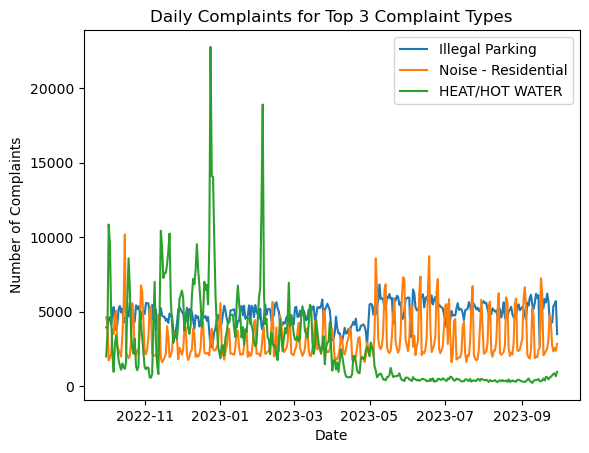

In [129]:
import matplotlib.pyplot as plt
conn = psycopg2.connect("dbname=FINAL_PROJECT user=postgres password=123456")
cur = conn.cursor()
visualize_1 = """
    SELECT
        complaint_type,
        COUNT(*) AS number_of_complaints
    FROM
        (SELECT * FROM complaints311_2022 WHERE created_date >= '2022-10-01'
        UNION ALL
        SELECT * FROM complaints311_2023 WHERE created_date <= '2023-09-30') AS combined_data
    WHERE
        created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY
        complaint_type
    ORDER BY
        number_of_complaints DESC
    LIMIT 3;
"""
cur.execute(visualize_1)
top_complaints = pd.DataFrame(cur.fetchall(), columns=['complaint_type', 'number_of_complaints'])

for complaint_type in top_complaints['complaint_type']:
    # SQL query to get daily complaints for each complaint type
    daily_complaints_query = f"""
        SELECT
            created_date,
            COUNT(*) AS daily_complaints
        FROM
            (SELECT * FROM complaints311_2022 WHERE created_date >= '2022-10-01'
            UNION ALL
            SELECT * FROM complaints311_2023 WHERE created_date <= '2023-09-30') AS combined_data
        WHERE
            created_date BETWEEN '2022-10-01' AND '2023-09-30'
            AND complaint_type = '{complaint_type}'
        GROUP BY
            created_date
        ORDER BY
            created_date;
    """

    cur.execute(daily_complaints_query)
    daily_complaints = pd.DataFrame(cur.fetchall(), columns=['created_date', 'daily_complaints'])
    
    plt.plot(daily_complaints['created_date'], daily_complaints['daily_complaints'], label=complaint_type)

# Customize the plot
plt.title('Daily Complaints for Top 3 Complaint Types')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend()
plt.show()

# Close the connection
conn.close()


### Visualization 2: What are the most common complaints in the immediate area?


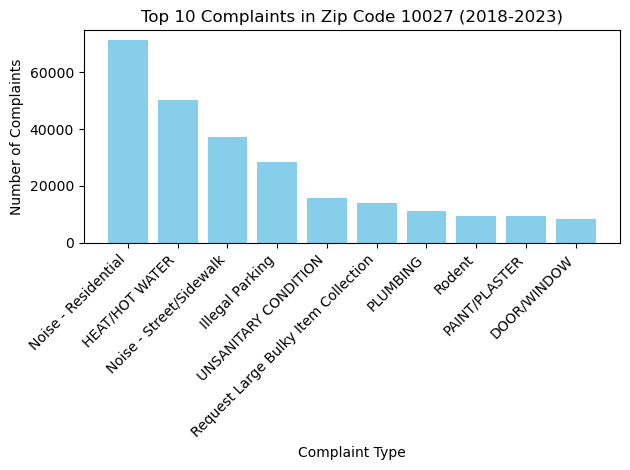

In [133]:
conn = psycopg2.connect("dbname=FINAL_PROJECT user=postgres password=123456")
cur = conn.cursor()

table_names = [f'complaints311_{year}' for year in range(2018, 2024)]

# SQL query to get the top 10 complaints in zip code 10027
visualize_2 = f"""
    SELECT
        complaint_type,
        COUNT(*) AS number_of_complaints
    FROM
        ({' UNION ALL '.join(f'SELECT * FROM {table}' for table in table_names)}) AS combined_data
    WHERE
        incident_zip = 10027
    GROUP BY
        complaint_type
    ORDER BY
        number_of_complaints DESC
    LIMIT 10;
"""

cur.execute(top_10_complaints_query)
top_10_complaints = pd.DataFrame(cur.fetchall(), columns=['complaint_type', 'number_of_complaints'])

# Plotting
plt.bar(top_10_complaints['complaint_type'], top_10_complaints['number_of_complaints'], color='skyblue')

# Customize the plot
plt.title('Top 10 Complaints in Zip Code 10027 (2018-2023)')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Close the connection
conn.close()

### Visualization 3: Is there any correlation between rent, trees, and complaints at all?
